# Sensor Projection

In this tutorial, we will demonstrate how to define a **sensor geometry** and project its trace onto the **Earth**.

## Setup

Let's import the necessary dependencies:

In [1]:
import numpy as np
import pandas as pd

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected = True)

import Library.Mathematics as Mathematics
import Library.Physics as Physics

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

to-Python converter for library::physics::time::DateTime already registered; second conversion method ignored.

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

to-Python converter for library::math::obj::IntervalBase::Type already registered; second conversion method ignored.



Then, we define some useful shortcuts:

In [2]:
Object2 = Mathematics.Geometry.D2.Object
Point2 = Mathematics.Geometry.D2.Objects.Point
Polygon2 = Mathematics.Geometry.D2.Objects.Polygon
Point3 = Mathematics.Geometry.D3.Objects.Point
Polygon3 = Mathematics.Geometry.D3.Objects.Polygon
Ellipsoid = Mathematics.Geometry.D3.Objects.Ellipsoid
Pyramid = Mathematics.Geometry.D3.Objects.Pyramid

Length = Physics.Units.Length
Angle = Physics.Units.Angle
Scale = Physics.Time.Scale
Instant = Physics.Time.Instant
Duration = Physics.Time.Duration
Interval = Physics.Time.Interval
DateTime = Physics.Time.DateTime
LLA = Physics.Coordinate.Spherical.LLA
Position = Physics.Coordinate.Position
Frame = Physics.Coordinate.Frame
Environment = Physics.Environment
Geometry = Physics.Environment.Object.Geometry
Earth = Physics.Environment.Objects.CelestialBodies.Earth

---

## Scene

We first set up a simple scene, with the Earth only (the default `Environment` will suffice here):

In [3]:
environment = Environment.Default() ;

Then, we access the `Earth` object (managed by the `Environment`):

In [4]:
earth = environment.accessObjectWithName("Earth")

Once the `Earth` has been obtained, we can also get its geometry (an `Ellipsoid`, defined in `ITRF` in this case):

In [5]:
earth_geometry = earth.getGeometryIn(Frame.ITRF())

## Sensor

Let's define a pyramidal geometry:

In [6]:
apex = Point3(7000e3, 0.0, 0.0)
base = Polygon3(Polygon2([Point2(-1.0, -1.0), Point2(+1.0, -1.0), Point2(+1.0, +1.0), Point2(-1.0, +1.0)]), apex - np.array((0.8, 0.0, 0.0)), np.array((0.0, 1.0, 0.0)), np.array((0.0, 0.0, 1.0)))

pyramid = Pyramid(base, apex)

That we express in `ITRF`:

In [7]:
sensor_geometry = Geometry(pyramid, Frame.ITRF())

## Intersection

Now that we have both Earth and sensor geometries clearly defined, we can compute their intersection:

In [8]:
intersection_ITRF = sensor_geometry.intersectionWith(earth_geometry)

And convert this 3D intersection into a 2D set of geodetic points:

In [9]:
intersection_points = [Point2(lla.getLongitude().inDegrees(), lla.getLatitude().inDegrees()) for lla in [LLA.Cartesian(point_ITRF.asVector(), Earth.EquatorialRadius, Earth.Flattening) for point_ITRF in intersection_ITRF.accessComposite().accessObjectAt(0).asLineString()]]

We further convert this set into a Pandas Dataframe, as a very convenient way for storing / managing data in Python:

In [10]:
intersection_df = pd.DataFrame([[float(intersection_point.x()), float(intersection_point.y())] for intersection_point in intersection_points], columns=['Longitude', 'Latitude']) ;

In [11]:
intersection_df.head()

,Longitude,Latitude
0,-8.768110,-8.724722
1,-8.152081,-5.915811
2,-7.861134,-3.893096
3,-7.713082,-2.226165
4,-7.649110,-0.725557


Now, we're ready to visualize the intersection on a map!

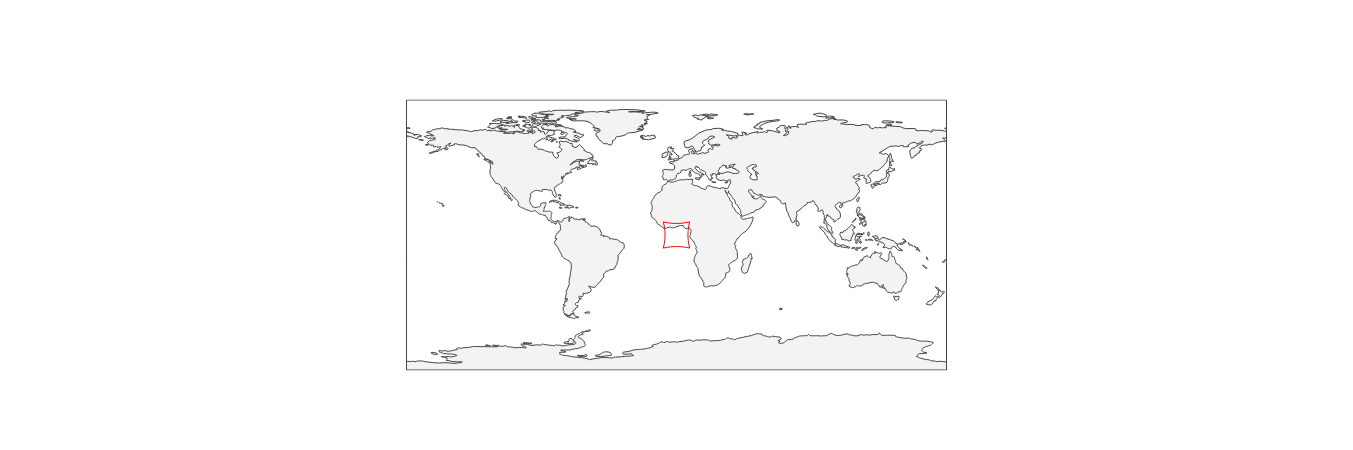

In [12]:
data = []

data.append(
    dict(
        type = 'scattergeo',
        lon = intersection_df['Longitude'],
        lat = intersection_df['Latitude'],
        mode = 'lines',
        line = dict(
            width = 1,
            color = 'red',
        )
    )
)
    
layout = dict(
        title = None,
        showlegend = False, 
        geo = dict(
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
    )
    
fig = dict(data=data, layout=layout)
iplot(fig)

It is also possible to obtain the `WKT` representation of the intersection polygon:

In [14]:
Polygon2(intersection_points).toString(Object2.Format.WKT)

POLYGON((-8.76811 -8.72472,-8.15208 -5.91581,-7.86113 -3.8931,-7.71308 -2.22617,-7.64911 -0.725557,-7.64911 0.725557,-7.71308 2.22617,-7.86113 3.8931,-8.15208 5.91581,-8.76811 8.72472,-8.76811 8.72472,-5.93863 8.16636,-3.90611 7.90015,-2.23303 7.76406,-0.727714 7.70513,0.727714 7.70513,2.23303 7.76406,3.90611 7.90015,5.93863 8.16636,8.76811 8.72472,8.76811 8.72472,8.15208 5.91581,7.86113 3.8931,7.71308 2.22617,7.64911 0.725557,7.64911 -0.725557,7.71308 -2.22617,7.86113 -3.8931,8.15208 -5.91581,8.76811 -8.72472,8.76811 -8.72472,5.93863 -8.16636,3.90611 -7.90015,2.23303 -7.76406,0.727714 -7.70513,-0.727714 -7.70513,-2.23303 -7.76406,-3.90611 -7.90015,-5.93863 -8.16636,-8.76811 -8.72472,-8.76811 -8.72472))